In [1]:
import random
import numpy as np
import torch
import torch.distributions as D
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from cutbayesflow import CutBayesFlow, train_cut_bayes_flow

# ─────────────────────────────────────────────
#  Reproducibility & Common Settings
# ─────────────────────────────────────────────
seed = 1010
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = "cpu"

alpha, beta = 2.0, 1.0
eta_dist = D.Gamma(concentration=alpha, rate=beta)
N_MC = 1000
eta_samples = eta_dist.sample((N_MC,1))
theta_grid = torch.linspace(-8,8,500).unsqueeze(1)

# ─────────────────────────────────────────────
#  Mixture‑of‑Gaussians target definitions
# ─────────────────────────────────────────────
def pi1_fn(eta):
    return (0.2 + 0.5 * torch.sigmoid(4 * (eta - 2.0))).clamp(1e-6, 1-1e-6)

def mu1_fn(eta):
    return 4.0 * torch.tanh(eta - 1.0)

def mu2_fn(eta):
    return -4.0 * torch.tanh(eta + 1.0)

sigma1, sigma2 = 1.5, 1.5  

def posterior_log_p_theta_given_eta(theta, eta, data=None):
    p1 = torch.exp(D.Normal(mu1_fn(eta), sigma1).log_prob(theta))
    p2 = torch.exp(D.Normal(mu2_fn(eta), sigma2).log_prob(theta))
    return torch.log(pi1_fn(eta) * p1 + (1 - pi1_fn(eta)) * p2 + 1e-8)

def dummy_prior(theta):
    return torch.zeros(theta.size(0))

with torch.no_grad():
    theta = theta_grid.expand(-1,N_MC)
    eta = eta_samples.t().expand(theta_grid.size(0),-1)
    log_mix = posterior_log_p_theta_given_eta(theta,eta)
    log_p_marg = torch.logsumexp(log_mix, dim=1) - torch.log(torch.tensor(N_MC,dtype=torch.float))
    p_theta_true = torch.exp(log_p_marg)



In [2]:
# ─────────────────────────────────────────────
#  NeVI_Cut_NSF(AR)
# ─────────────────────────────────────────────
print("Training NeVI_Cut_NSF(AR)")
model_nevi=CutBayesFlow(
    prior_log_prob_fn=dummy_prior,
    likelihood_log_prob_fn=posterior_log_p_theta_given_eta,
    eta_dim=1, theta_dim=1,
    num_layers=6, hidden_features=16,
    num_bins=25, tail_bound=15.0,
    use_residual_blocks=True, num_blocks=2
)

loss_history_nsf = train_cut_bayes_flow(
    model_nevi,
    eta_samples,
    None,
    epochs=2000,
    lr=5e-3,
    log_interval=200,
    seed=seed,
    verbose=True
)
print("NeVI_Cut_NSF(AR) is finished")


Training NeVI_Cut_NSF(AR)
Using batch_size=1000 (full-batch: True)
Step     0 | Loss: 12.632399 | LR: 5.00e-03
Step   200 | Loss: 0.114815 | LR: 5.00e-03
Step   400 | Loss: 0.120762 | LR: 5.00e-03
Epoch 00404: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00586: reducing learning rate of group 0 to 1.2500e-03.
Step   600 | Loss: 0.022934 | LR: 1.25e-03
Epoch 00784: reducing learning rate of group 0 to 6.2500e-04.
Step   800 | Loss: 0.015093 | LR: 6.25e-04
Epoch 00984: reducing learning rate of group 0 to 3.1250e-04.
Step  1000 | Loss: -0.002148 | LR: 3.13e-04
Epoch 01085: reducing learning rate of group 0 to 1.5625e-04.
Epoch 01186: reducing learning rate of group 0 to 7.8125e-05.
Step  1200 | Loss: 0.002660 | LR: 7.81e-05
Epoch 01287: reducing learning rate of group 0 to 3.9063e-05.
Epoch 01388: reducing learning rate of group 0 to 1.9531e-05.
Step  1400 | Loss: -0.001305 | LR: 1.95e-05
Epoch 01489: reducing learning rate of group 0 to 9.7656e-06.
Epoch 01590: reducing learni

In [3]:
# ─────────────────────────────────────────────
#  NeVI_Cut_UMNN
# ─────────────────────────────────────────────
print("Training NeVI_Cut_UMNN")

model_mono=CutBayesFlow(
    prior_log_prob_fn=dummy_prior,
    likelihood_log_prob_fn=posterior_log_p_theta_given_eta,
    eta_dim=1, theta_dim=1,
    num_layers=1, hidden_features=128,
    flow_type="UMNN"
)

loss_history_mono = train_cut_bayes_flow(
    model_mono,
    eta_samples,
    None,
    epochs=2000,
    lr=5e-3,
    log_interval=200,
    seed=seed,
    verbose=True
)

print("NeVI_Cut_UMNN is complete")

Training NeVI_Cut_UMNN
Using batch_size=1000 (full-batch: True)
Step     0 | Loss: 2.107691 | LR: 5.00e-03
Step   200 | Loss: 0.061542 | LR: 5.00e-03
Epoch 00360: reducing learning rate of group 0 to 2.5000e-03.
Step   400 | Loss: 0.028941 | LR: 2.50e-03
Epoch 00571: reducing learning rate of group 0 to 1.2500e-03.
Step   600 | Loss: 0.018735 | LR: 1.25e-03
Epoch 00672: reducing learning rate of group 0 to 6.2500e-04.
Epoch 00773: reducing learning rate of group 0 to 3.1250e-04.
Step   800 | Loss: 0.013922 | LR: 3.13e-04
Epoch 00874: reducing learning rate of group 0 to 1.5625e-04.
Epoch 00984: reducing learning rate of group 0 to 7.8125e-05.
Step  1000 | Loss: 0.011947 | LR: 7.81e-05
Epoch 01085: reducing learning rate of group 0 to 3.9063e-05.
Epoch 01186: reducing learning rate of group 0 to 1.9531e-05.
Step  1200 | Loss: 0.005773 | LR: 1.95e-05
Epoch 01287: reducing learning rate of group 0 to 9.7656e-06.
Epoch 01388: reducing learning rate of group 0 to 4.8828e-06.
Step  1400 | Lo

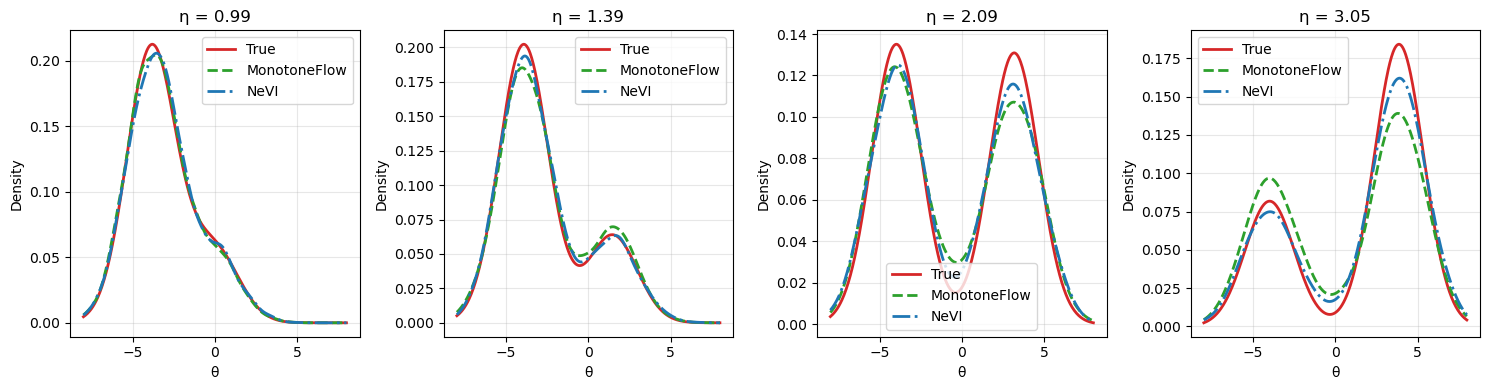

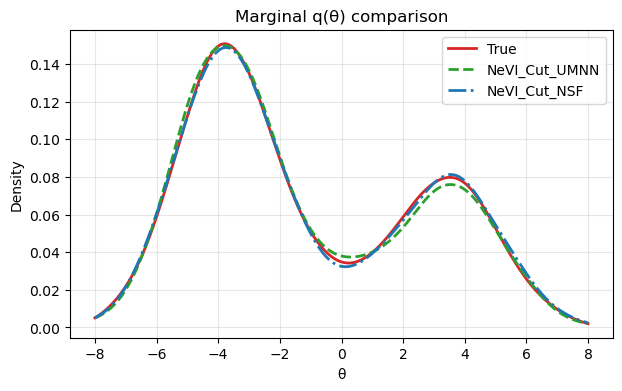

In [ ]:
seed = 1010
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# ─────────────────────────────────────────────
#  Diagnostics & Comparison Plots
# ─────────────────────────────────────────────
colors = {
    'True': '#D62728',   
    'Mono': '#2CA02C',   
    'NeVI': '#1F77B4',  
}

x = theta_grid.numpy().ravel()  

conditional_samples = {}
conditional_truths = {}
eta_vals = [eta_samples.quantile(q, 0).item() for q in [0.25, 0.4, 0.6, 0.8]]

fig, axes = plt.subplots(1, len(eta_vals), figsize=(15, 4))
for ax, ev in zip(axes, eta_vals):
    with torch.no_grad():
        # True conditional
        logp = posterior_log_p_theta_given_eta(theta_grid, torch.full_like(theta_grid, ev))
        p_true = torch.exp(logp).numpy().ravel()
        conditional_truths[f"eta_{ev:.2f}_true"] = p_true

        # NeVI.Cut.UMNN
        qm = model_mono.sample_q_theta_given_eta(torch.full((5000, 1), ev)).detach().numpy().ravel()
        conditional_samples[f"eta_{ev:.2f}_mono"] = qm

        # NeVI.Cut.NSF(AR)
        qt = model_nevi.sample_q_theta_given_eta(torch.full((5000, 1), ev)).detach().numpy().ravel()
        conditional_samples[f"eta_{ev:.2f}_nevi"] = qt

    # Plot
    ax.plot(x, p_true, color=colors['True'], linewidth=2, label='True')
    ax.plot(x, gaussian_kde(qm)(x), color=colors['Mono'], linestyle='--', linewidth=2, label='MonotoneFlow')
    ax.plot(x, gaussian_kde(qt)(x), color=colors['NeVI'], linestyle='-.', linewidth=2, label='NeVI')
    ax.set_title(f"η = {ev:.2f}")
    ax.set_xlabel("θ")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

with torch.no_grad():
    idx = torch.randint(0, eta_samples.shape[0], (10000,))
    tm = model_mono.sample_q_theta_given_eta(eta_samples[idx]).detach().numpy().ravel()
    tn = model_nevi.sample_q_theta_given_eta(eta_samples[idx]).detach().numpy().ravel()

true_marginal_samples = []
with torch.no_grad():
    for _ in range(10000):
        eta_i = eta_dist.sample().item()
        logp = posterior_log_p_theta_given_eta(theta_grid, torch.full_like(theta_grid, eta_i))
        p = torch.exp(logp).numpy().ravel()
        p /= p.sum()
        theta_sample = np.random.choice(x, p=p)
        true_marginal_samples.append(theta_sample)
marginal_true = np.array(true_marginal_samples)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(x, gaussian_kde(marginal_true)(x), color=colors['True'], linewidth=2, label='True')
plt.plot(x, gaussian_kde(tm)(x), color=colors['Mono'], linestyle='--', linewidth=2, label='NeVI_Cut_UMNN')
plt.plot(x, gaussian_kde(tn)(x), color=colors['NeVI'], linestyle='-.', linewidth=2, label='NeVI_Cut_NSF')
plt.title("Marginal q(θ) comparison")
plt.xlabel("θ")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

